In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [1]:
bs = 64
SEED = 2

In [3]:
path = untar_data(URLs.PETS)/'images'

In [4]:
path.ls()[:5]

[WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),
 WindowsPath('C:/Users/sepolt/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg')]

In [5]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [6]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=SEED).label_from_re(r'([^/]+)_\d+.jpg$')

In [7]:
def get_data(size, bs, padding_mode='reflection'):
    return src.transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [8]:
data = get_data(224, bs, 'zeros')

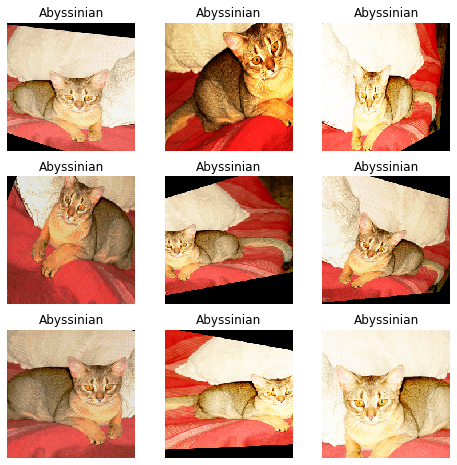

In [9]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [12]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [13]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


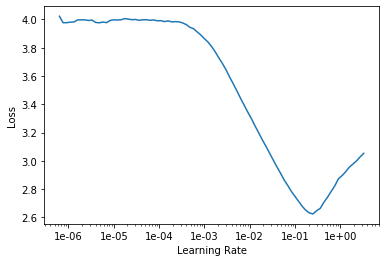

In [15]:
learner.recorder.plot()

In [16]:
learner.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.661265,0.381979,0.094723,04:55
1,0.994993,0.287648,0.087280,03:18
2,0.711172,0.257394,0.077808,02:42


In [17]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.603000,0.258698,0.071719,02:29
1,0.556209,0.243111,0.059540,02:19


In [24]:
learner.save('224')

In [15]:
gc.collect()

20

In [16]:
del learner
torch.cuda.empty_cache()

In [10]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('224')

In [11]:
data = get_data(352,32)
learner.data = data

In [12]:
learner.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.742814,0.253986,0.054804,06:44
1,0.710567,0.247019,0.054127,03:55


In [13]:
learner.save('352')

In [14]:
learner.destroy()
del learner
torch.cuda.empty_cache()

this Learner object self-destroyed - it still exists, but no longer usable


In [17]:
learner = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

In [19]:
data.c

37

In [18]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [33]:
# m[0] is the convolutional part of the model
m = learner.model.eval()

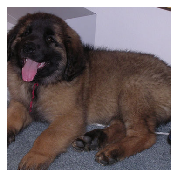

In [34]:
x,y = data.valid_ds[5]
x.show()

In [35]:
xb,_ = data.one_item(x) # creates a minibatch with the one element in it
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [38]:
from fastai.callbacks.hooks import *

In [39]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [40]:
hook_a,hook_g = hooked_backward()

In [44]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [46]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [45]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

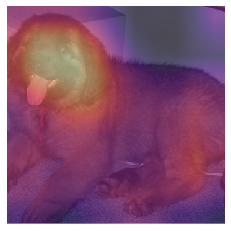

In [47]:
show_heatmap(avg_acts)